In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import torch
import os

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets


class MNISTDataset(Dataset):
    def __init__(self, root, train, blanks):
        path = os.path.join(root, "train" if train else "test")
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        self.images = load_images(image_path)
        self.labels = load_labels(label_path)

        add_blank(self.images, self.labels, blanks)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]

        images = torch.tensor(images, dtype=torch.float32).reshape(1, 28, 28)
        labels = torch.tensor(labels, dtype=torch.long)

        return images, labels

In [3]:
root = r"C:\Users\trand\longg\code\python\deep learning\mnist\pytorch"

train_image_dataset = MNISTDataset(root + "\mnist", train=True, blanks=5500)
test_image_dataset = MNISTDataset(root + "\mnist", train=False, blanks=900)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\trand\AppData\Local\Temp\ipykernel_2084\1653993895.py:3: SyntaxWarning: invalid escape sequence '\m'
  train_image_dataset = MNISTDataset(root + "\mnist", train=True, blanks=5500)
C:\Users\trand\AppData\Local\Temp\ipykernel_2084\1653993895.py:4: SyntaxWarning: invalid escape sequence '\m'
  test_image_dataset = MNISTDataset(root + "\mnist", train=False, blanks=900)


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)


print(device)

cuda


In [5]:
from torch import nn
from torch.nn import functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.dense_layer = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=128),
            nn.ReLU(),
            #
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = self.flatten(x)
        x = self.dense_layer(x)
        return x


cnn = CNN().to(device)

In [6]:
train_cost = []
test_cost = []
train_accuracy = []
test_accuracy = []


def train(model, dataloader, optimizer, criterion):
    model.train()
    cost = 0
    accuracy = 0

    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        cost += loss.item()
        accuracy += (y_pred.argmax(-1) == y).sum().item()

    size = len(dataloader.dataset)
    cost /= size
    accuracy /= size

    train_cost.append(cost)
    train_accuracy.append(accuracy)
    print(f"Train Cost: {cost}, Train Accuracy: {accuracy*100}%")


def test(model, dataloader, criterion):
    model.eval()
    cost = 0
    accuracy = 0

    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)

        cost += loss.item()
        accuracy += (y_pred.argmax(dim=-1) == y).sum().item()

    size = len(dataloader.dataset)
    cost /= size
    accuracy /= size
    print(f"Test Cost: {cost}, Test Accuracy: {accuracy*100}%")

    test_cost.append(cost)
    test_accuracy.append(accuracy)

In [7]:
from torch import optim

batch_size = 64
test_image_dataloader = DataLoader(
    dataset=test_image_dataset, batch_size=batch_size, shuffle=True
)
train_image_dataloader = DataLoader(
    dataset=train_image_dataset, batch_size=batch_size, shuffle=True
)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epoch_size = 10
for epoch in range(epoch_size):
    print(f"Epoch {epoch+1}\n-----------------------------------")
    train(cnn, train_image_dataloader, optimizer, criterion)
    test(cnn, test_image_dataloader, criterion)

Epoch 1
-----------------------------------
Train Cost: 0.0035935042993398385, Train Accuracy: 94.305%
Test Cost: 0.0009457047460600733, Test Accuracy: 98.1%
Epoch 2
-----------------------------------
Train Cost: 0.0009320727136277128, Train Accuracy: 98.11666666666666%
Test Cost: 0.0007938333800251712, Test Accuracy: 98.41%
Epoch 3
-----------------------------------
Train Cost: 0.0006904268910113994, Train Accuracy: 98.60333333333332%
Test Cost: 0.0005872446427471004, Test Accuracy: 98.69%
Epoch 4
-----------------------------------
Train Cost: 0.0005789475302221641, Train Accuracy: 98.785%
Test Cost: 0.000618529850669438, Test Accuracy: 98.58%
Epoch 5
-----------------------------------
Train Cost: 0.0004818599646710936, Train Accuracy: 99.03333333333333%
Test Cost: 0.0006289233370262081, Test Accuracy: 98.85000000000001%
Epoch 6
-----------------------------------
Train Cost: 0.0004159337956141826, Train Accuracy: 99.15666666666667%
Test Cost: 0.0006386846388915728, Test Accuracy:

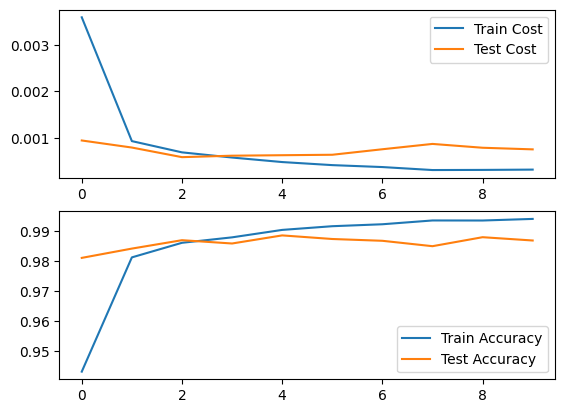

In [8]:
fig, axes = plt.subplots(2)

axes[0].plot(train_cost, label="Train Cost")
axes[0].plot(test_cost, label="Test Cost")
axes[0].legend()

axes[1].plot(train_accuracy, label="Train Accuracy")
axes[1].plot(test_accuracy, label="Test Accuracy")
axes[1].legend()

In [9]:
torch.save(
    {
        "epoch": epoch,
        "model_state_dict": cnn.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": criterion,
    },
    root + "\CNN\model\CNN_checkpoint",
)

<>:8: SyntaxWarning: invalid escape sequence '\C'
<>:8: SyntaxWarning: invalid escape sequence '\C'
C:\Users\trand\AppData\Local\Temp\ipykernel_2084\635889140.py:8: SyntaxWarning: invalid escape sequence '\C'
  root + "\CNN\model\CNN_checkpoint",


In [10]:
class SumMNISTDataset(Dataset):
    def __init__(self, root, train, blanks, sum_digit, size):
        path = os.path.join(root, "train" if train else "test")
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        images = load_images(image_path)
        labels = load_labels(label_path)

        add_blank(images, labels, blanks)
        self.images, self.labels = sum_dataset(images, labels, sum_digit, size)
        self.sum_digit = sum_digit

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]

        images = torch.tensor(images, dtype=torch.float32).reshape(
            self.sum_digit, 1, 28, 28
        )
        labels = torch.tensor(labels, dtype=torch.float32)

        return images, labels

In [11]:
train_sum_dataset = SumMNISTDataset(
    root + "\mnist", train=True, blanks=20000, sum_digit=10, size=220000
)

test_sum_dataset = SumMNISTDataset(
    root + "\mnist", train=False, blanks=1800, sum_digit=10, size=20000
)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\trand\AppData\Local\Temp\ipykernel_2084\1515971541.py:2: SyntaxWarning: invalid escape sequence '\m'
  root + "\mnist", train=True, blanks=20000, sum_digit=10, size=220000
C:\Users\trand\AppData\Local\Temp\ipykernel_2084\1515971541.py:6: SyntaxWarning: invalid escape sequence '\m'
  root + "\mnist", train=False, blanks=1800, sum_digit=10, size=20000


In [12]:
for param in cnn.parameters():
    param.requires_grad = False

In [13]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=10, hidden_size=128, num_layers=1, batch_first=True
        )
        self.fc1 = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        x, (_, _) = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        return x


lstm = LSTM().to(device)

In [14]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn, lstm):
        super().__init__()
        self.cnn = cnn
        self.lstm = lstm

    def forward(self, x):
        x_seq = []
        num_images = x.shape[1]

        for i in range(num_images):
            x_seq.append(self.cnn(x[:, i, :, :]))

        x_seq = torch.stack(x_seq, dim=1)
        output = self.lstm(x_seq)

        return output.squeeze()


cnn_lstm = CNN_LSTM(cnn, lstm).to(device)

In [15]:
test_mse = []
test_mae = []


train_mse = []
train_mae = []


def train_CNN_LSTM(model, dataloader, criterion, optimizer):
    model.train()

    cost = 0
    diff = 0

    for batch, (x, y) in enumerate(dataloader):

        x = x.to(device)

        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        loss.backward()

        optimizer.step()

        diff += torch.abs((y_pred - y)).sum().item()

        cost += loss.item()

    size = len(dataloader.dataset)

    cost /= size
    diff /= size
    train_mse.append(cost)
    train_mae.append(diff)

    print(f"Train Cost: {cost: .5f}, Train MAE: {diff: .5f}")


def test_CNN_LSTM(model, dataloader, criterion):

    model.eval()

    cost = 0

    diff = 0

    for batch, (x, y) in enumerate(dataloader):

        x = x.to(device)

        y = y.to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y)

        diff += torch.abs(y_pred - y).sum().item()

        cost += loss.item()

    size = len(dataloader.dataset)
    diff /= size

    cost /= size
    test_mse.append(cost)
    test_mae.append(diff)

    print(f"Test Cost: {cost: .5f}, Test MAE: {diff: .5f}")

In [16]:
torch.random.manual_seed(2)

batch_size = 256

test_sum_dataloader = DataLoader(
    dataset=test_sum_dataset, batch_size=batch_size, shuffle=True
)
train_sum_dataloader = DataLoader(
    dataset=train_sum_dataset, batch_size=batch_size, shuffle=True
)

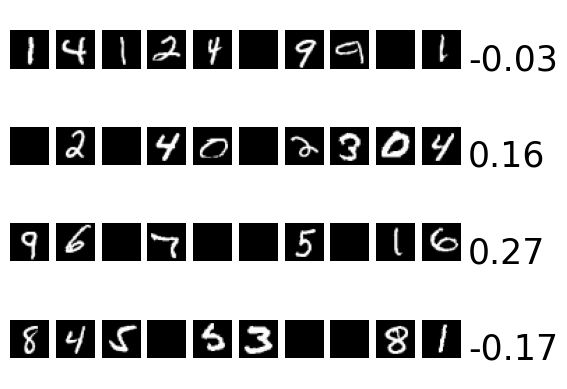

In [17]:
(batch_x, batch_y) = next(iter(train_sum_dataloader))
batch_y_pred = cnn_lstm(batch_x.to(device))

fig, axes = plt.subplots(4, 11)

for i, row in enumerate(axes):
    images = batch_x[i].squeeze()
    label = batch_y_pred[i]

    row_size = len(images)
    for j in range(row_size):
        row[j].imshow(
            images[j],
            cmap="gray",
        )
        row[j].axis("off")

    row[row_size].text(0, 0.25, f"{label:.2f}", fontsize=25)
    row[row_size].axis("off")

In [18]:
optimizer = optim.Adam(cnn_lstm.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.MSELoss()

epoch_size = 20


for epoch in range(epoch_size):

    print(f"Epoch {epoch+1}\n-----------------------------------")

    train_CNN_LSTM(cnn_lstm, train_sum_dataloader, criterion, optimizer)

    test_CNN_LSTM(cnn_lstm, test_sum_dataloader, criterion)

Epoch 1
-----------------------------------
Train Cost:  0.67106, Train MAE:  10.06706
Test Cost:  0.47319, Test MAE:  8.73356
Epoch 2
-----------------------------------
Train Cost:  0.09213, Train MAE:  3.00502
Test Cost:  0.03278, Test MAE:  1.84996
Epoch 3
-----------------------------------
Train Cost:  0.01142, Train MAE:  1.15795
Test Cost:  0.01783, Test MAE:  1.42043
Epoch 4
-----------------------------------
Train Cost:  0.00731, Train MAE:  0.94417
Test Cost:  0.01180, Test MAE:  1.12976
Epoch 5
-----------------------------------
Train Cost:  0.00580, Train MAE:  0.84280
Test Cost:  0.00990, Test MAE:  1.04327
Epoch 6
-----------------------------------
Train Cost:  0.00505, Train MAE:  0.78969
Test Cost:  0.01005, Test MAE:  1.05804
Epoch 7
-----------------------------------
Train Cost:  0.00447, Train MAE:  0.73563
Test Cost:  0.00837, Test MAE:  0.94940
Epoch 8
-----------------------------------
Train Cost:  0.00413, Train MAE:  0.70637
Test Cost:  0.00818, Test MAE: 

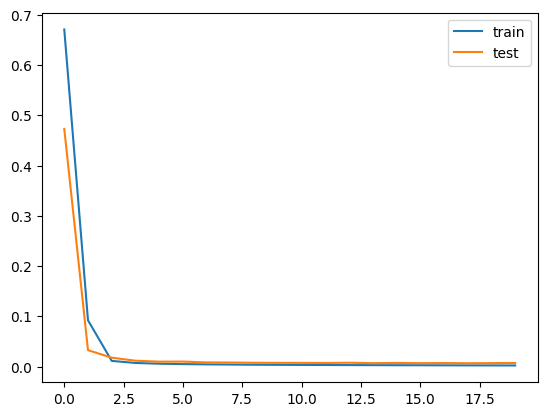

In [19]:
plt.plot(train_mse, label="train")
plt.plot(test_mse, label="test")
plt.legend()

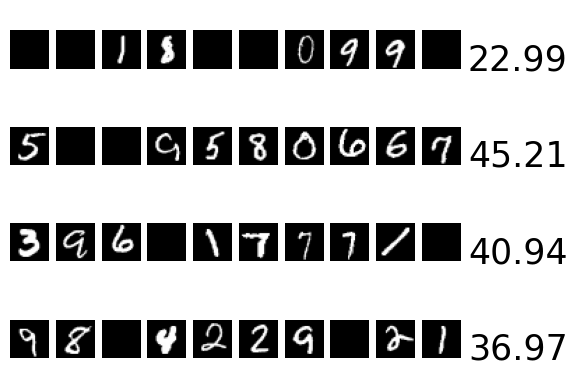

In [20]:
(batch_x, batch_y) = next(iter(train_sum_dataloader))
batch_y_pred = cnn_lstm(batch_x.to(device))

fig, axes = plt.subplots(4, 11)

for i, row in enumerate(axes):
    images = batch_x[i].squeeze()
    label = batch_y_pred[i]

    row_size = len(images)
    for j in range(row_size):
        row[j].imshow(
            images[j],
            cmap="gray",
        )
        row[j].axis("off")

    row[row_size].text(0, 0.25, f"{label:.2f}", fontsize=25)
    row[row_size].axis("off")